## Imports

In [1]:
#Basic
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import re

#Text processing
import nltk as nl
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 

#Feature extraction and data preparation for model
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split

#Model
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neural_network import MLPClassifier

#Evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

In [2]:
#Download resources from nltk
nl.download('wordnet')
nl.download('omw-1.4')
nl.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

## Dataset

In [4]:
#covert text file into dataframe
def convert_to_df(file):
    with open(file, 'r') as f:
        data = f.readlines()
    data = [x.strip() for x in data]
    data = [x.split('\t') for x in data]
    df = pd.DataFrame(data)
    df.columns = ['text', 'label']
    return df

In [5]:
#read text files and convert to dataframe
imdb = convert_to_df('imdb_labelled.txt')
amazon = convert_to_df('amazon_cells_labelled.txt')
yelp = convert_to_df('yelp_labelled.txt')

In [6]:
#combine all dataframes into one
df = pd.concat([imdb, amazon, yelp], ignore_index=True)
df

,text,label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
...,...,...
2995,I think food should have flavor and texture an...,0
2996,Appetite instantly gone.,0
2997,Overall I was not impressed and would not go b...,0
2998,"The whole experience was underwhelming, and I ...",0


## Clean Text

In [7]:
#The clean text function allows you to convert all letters to lowercase, remove numbers, punctuation and all words that have less than 3 characters
def clean_text(text):
    new_text=text.lower()
    clean_text= re.sub("[^a-z]+"," ",new_text)
    clean_text_stop_removed = ""
    for w in clean_text.split(" ")[1:]:
        if not w in stop_words and len(w) > 3:
            clean_text_stop_removed += w
            clean_text_stop_removed += " "
            clean_text_stop_removed=lemmatizer.lemmatize(clean_text_stop_removed)
            clean_text_stop_removed=stemmer.stem(clean_text_stop_removed)
    return clean_text_stop_removed

In [8]:
#Apply the function on total dataset
df["text_clean"] = df.text.apply(clean_text)

In [9]:
df.head()

,text,label,text_clean
0,"A very, very, very slow-moving, aimless movie ...",0,slow moving aimless movie distressed drifting ...
1,Not sure who was more lost - the flat characte...,0,sure lost flat characters audience nearly half...
2,Attempting artiness with black & white and cle...,0,artiness black white clever camera angles movi...
3,Very little music or anything to speak of.,0,little music anything speak
4,The best scene in the movie was when Gerardo i...,1,best scene movie gerardo trying find song keep...


In [10]:
df = df.drop(['text'], axis=1)
df

,label,text_clean
0,0,slow moving aimless movie distressed drifting ...
1,0,sure lost flat characters audience nearly half...
2,0,artiness black white clever camera angles movi...
3,0,little music anything speak
4,1,best scene movie gerardo trying find song keep...
...,...,...
2995,0,think food flavor texture lacking
2996,0,instantly gone
2997,0,impressed would back
2998,0,whole experience underwhelming think ninja sus...


In [11]:
#Add length feature
df['len'] = df['text_clean'].str.len()
df

,label,text_clean,len
0,0,slow moving aimless movie distressed drifting ...,52
1,0,sure lost flat characters audience nearly half...,54
2,0,artiness black white clever camera angles movi...,123
3,0,little music anything speak,28
4,1,best scene movie gerardo trying find song keep...,61
...,...,...,...
2995,0,think food flavor texture lacking,34
2996,0,instantly gone,15
2997,0,impressed would back,21
2998,0,whole experience underwhelming think ninja sus...,59


## Visualize Data

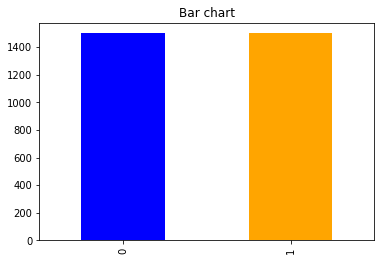

In [12]:
#Bar plot of class labels
plt.rcParams['figure.figsize'] = (6, 4)
count_Class=pd.value_counts(df["label"], sort= True)
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

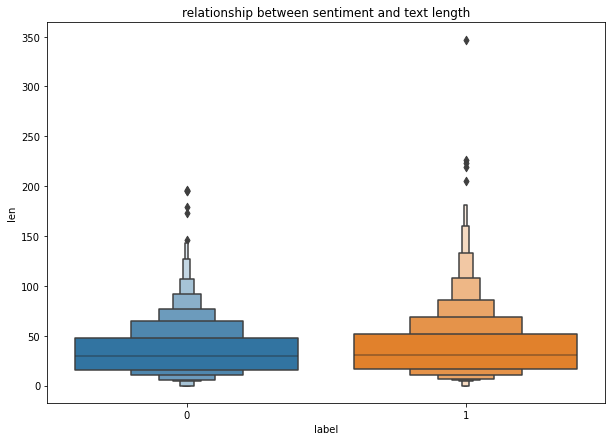

In [13]:
#Visualization of text length in positive and negative sentiment
plt.rcParams['figure.figsize'] = (10, 7)
sns.boxenplot(x = df['label'], y = df['len'])
plt.title('relationship between sentiment and text length')
plt.show()

## Word frequency

In [14]:
#word frequency
def word_freq(text):
    word_list = []
    for i in text:
        for j in i.split():
            word_list.append(j)
    return word_list

#word frequency in positive sentiment
pos_words = word_freq(df[df['label'] == '1']['text_clean'])
pos_freq = Counter(pos_words)
pos_freq.most_common(20)

#word frequency in negative sentiment
neg_words = word_freq(df[df['label'] == '0']['text_clean'])
neg_freq = Counter(neg_words)
neg_freq.most_common(20)

neg_df = pd.DataFrame(neg_freq.most_common(20), columns = ['words', 'count'])
pos_df = pd.DataFrame(pos_freq.most_common(20), columns = ['words', 'count'])

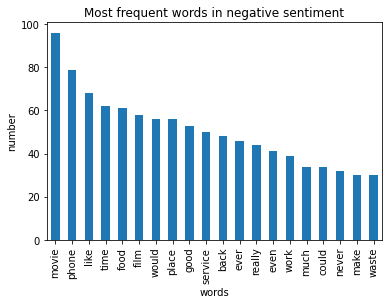

In [15]:
plt.rcParams['figure.figsize'] = (6, 4)
neg_df.plot.bar(legend = False)
y_pos = np.arange(len(neg_df["words"]))
plt.xticks(y_pos, neg_df["words"])
plt.title('Most frequent words in negative sentiment')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

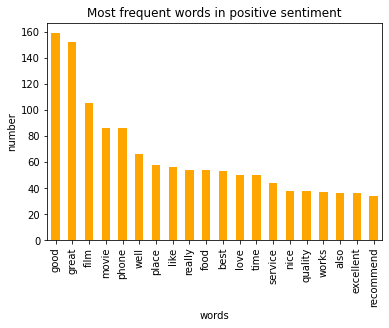

In [16]:
plt.rcParams['figure.figsize'] = (6, 4)
pos_df.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(pos_df["words"]))
plt.xticks(y_pos, pos_df["words"])
plt.title('Most frequent words in positive sentiment')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

In [17]:
# from wordcloud import WordCloud
# # text = ' '.join(dataset_mails_clean.text_clean.values)
# text = ' '.join(df[df['label']==1].text_clean.values)

# wordcloud = WordCloud(max_font_size=50, max_words=1000, background_color="white",  colormap='BuGn').generate(text.lower())
# plt.figure(figsize=(15,15))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

## Train Test Data

In [18]:
x = df['text_clean']
y = df['label']

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2)
print(x_train.shape, x_test.shape)

(2400,) (600,)


In [20]:
print("Samples per class in train {}".format(np.bincount(y_train)))
print("Samples per class in test {}".format(np.bincount(y_test)))

Samples per class in train [1201 1199]
Samples per class in test [299 301]


## Feature Extraction: TF-IDF Feature 

In [21]:
tfidf = TfidfVectorizer()

In [22]:
train_tfidf = tfidf.fit_transform(x_train)
test_tfidf = tfidf.transform(x_test)

In [23]:
cv_df = pd.DataFrame(train_tfidf.toarray(),columns = tfidf.get_feature_names_out())
cv_df

,abhor,ability,able,abound,abroad,absolute,absolutely,absolutley,abstruse,abysmal,...,young,younger,youthful,yucky,yukon,yummy,zero,zillion,zombie,zombiez
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
feature_names = tfidf.get_feature_names_out()
print("Number of features: {}".format(len(feature_names)))

Number of features: 3930


In [25]:
## Preparing to make a pipeline 
models = {
    'Naive Bayes': MultinomialNB()
    # 'Bernoulli Naive Bayes': BernoulliNB(),
    # 'Perceptron': MLPClassifier()
}

params = {
    'Naive Bayes': { 'alpha': [0.5, 1], 'fit_prior': [True, False] },
    # 'Bernoulli Naive Bayes': { 'alpha': [0.5, 1], 'fit_prior': [True, False] },
    # 'Perceptron': { 'activation': ['tanh', 'relu'] }
}

In [26]:
# Use multiple classifiers and grid search for prediction
def ML_modeling(models, params, X_train, X_test, y_train, y_test, performance_metrics):    
    
    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Some estimators are missing parameters')

    for key in models.keys():
    
        model = models[key]
        param = params[key]

        gs = GridSearchCV(model, param, cv=10, error_score=0, refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        
        # Print scores for the classifier
        accuracy_sc = accuracy_score(y_test, y_pred)
        precision_sc= precision_score(y_test, y_pred, average='macro')
        recall_sc = recall_score(y_test, y_pred, average='macro')
        f1_sc =  f1_score(y_test, y_pred, average='macro')
        
        performance_metrics.append([key,accuracy_sc,precision_sc,recall_sc,f1_sc])
        print(key, ':', gs.best_params_)
        print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (accuracy_sc, precision_sc, recall_sc, f1_sc))

        sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,  fmt='g')
        plt.show()
        
    return 

==============TF-IDF==============

Naive Bayes : {'alpha': 0.5, 'fit_prior': True}
Accuracy: 0.747 	Precision: 0.747 	Recall: 0.747 		F1: 0.747



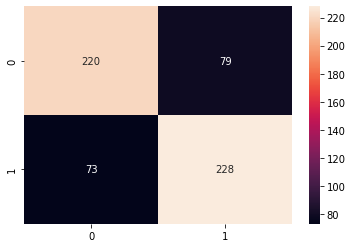

In [27]:
performance_metrics_tfidf = []
print("==============TF-IDF==============\n")
ML_modeling(models, params, train_tfidf, test_tfidf, y_train, y_test, performance_metrics_tfidf)
metrics_tfidf_df = pd.DataFrame(performance_metrics_tfidf,columns=['Model' , 'Accuracy', 'Precision' , 'Recall', "F1 Score"])

## Othe features

In [29]:
from gensim.models import Word2Vec
from tqdm import tqdm
from warnings import filterwarnings
filterwarnings('ignore')

In [30]:
words_in_sentences=[]
for i in tqdm(x_train):
    words_in_sentences.append(i.split())

100%|██████████| 2400/2400 [00:00<00:00, 402460.00it/s]


In [35]:
wv_model = Word2Vec(sentences=words_in_sentences,workers=-1)

In [37]:
vocab=list(wv_model.wv.index_to_key)
print(len(vocab))

528


In [38]:
def avg_w2vec(sentences):
    transformed=[]
    for sentence in tqdm(sentences):
        count=0
        vector=np.zeros(100)
        for word in sentence.split():
            if word in vocab:
                vector+=wv_model.wv.get_vector(word)
                count+=1
        if count!=0:
            vector/=count
            transformed.append(vector)
        else:
            # print(sentence)
            transformed.append(np.random.rand(100))
    
    return np.array(transformed)

In [39]:
x_train_transformed=avg_w2vec(x_train)
x_test_transformed=avg_w2vec(x_test)

100%|██████████| 600/600 [00:00<00:00, 12001.16it/s]


In [42]:
## Preparing to make a pipeline 
models = {
    # 'Naive Bayes': MultinomialNB(),
    # 'Bernoulli Naive Bayes': BernoulliNB(),
    'Perceptron': MLPClassifier()
}

params = {
    'Naive Bayes': { 'alpha': [0.5, 1], 'fit_prior': [True, False] },
    # 'Bernoulli Naive Bayes': { 'alpha': [0.5, 1], 'fit_prior': [True, False] },
    'Perceptron': { 'activation': ['tanh', 'relu'] }
}

============== Word2vec ==============

Perceptron : {'activation': 'relu'}
Accuracy: 0.643 	Precision: 0.643 	Recall: 0.643 		F1: 0.643



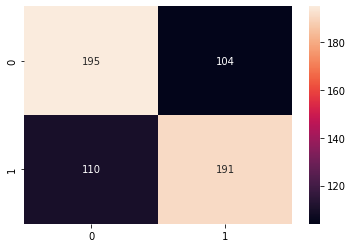

In [43]:
performance_metrics_wv = []
print("============== Word2vec ==============\n")
ML_modeling(models, params, x_train_transformed, x_test_transformed, y_train, y_test, performance_metrics_wv)
metrics_bow_df = pd.DataFrame(performance_metrics_wv,columns=['Model' , 'Accuracy', 'Precision' , 'Recall', "F1 Score"])